In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data Loading and Processing

In [2]:
def load_and_preprocess_monk_local(monk_id, data_dir="."):
    train_path = os.path.join(data_dir, f"monks-{monk_id}.train")
    test_path  = os.path.join(data_dir, f"monks-{monk_id}.test")

    columns = ["label", "a1", "a2", "a3", "a4", "a5", "a6", "id"]

    df_train = pd.read_csv(train_path, sep=r"\s+", names=columns, engine="python")
    df_test  = pd.read_csv(test_path,  sep=r"\s+", names=columns, engine="python")

    X_train_raw = df_train.iloc[:, 1:7].values
    y_train = df_train["label"].values.astype(int)

    X_test_raw = df_test.iloc[:, 1:7].values
    y_test = df_test["label"].values.astype(int)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoder.fit(X_train_raw)  # fit ONLY on training raw data

    X_train = encoder.transform(X_train_raw)
    X_test  = encoder.transform(X_test_raw)

    return X_train, y_train, X_test, y_test




# Build Searches

In [3]:
def build_searches():
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # -------- KNN --------
    knn_pipe = Pipeline([("clf", KNeighborsClassifier())])
    knn_grid = {
        "clf__n_neighbors": list(range(5, 25)),
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["euclidean", "manhattan"],
    }
    knn_search = GridSearchCV(
        knn_pipe, knn_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1, refit=True
    )

    # -------- SVM --------
    svm_pipe = Pipeline([("clf", SVC(probability=True, random_state=42))])
    svm_grid = {
        "clf__kernel": ["rbf", "poly", "linear"],
        "clf__C": [ 0.1, 1, 10, 100],
        "clf__gamma": ["scale", "auto", 0.01, 0.1, 1],
        "clf__degree": [2, 3, 4],
        "clf__coef0": [0, 1],
       
    }
    svm_search = GridSearchCV(
        svm_pipe, svm_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1, refit=True
    )

    # -------- Random Forest --------
    rf_pipe = Pipeline([("clf", RandomForestClassifier(random_state=42))])
    rf_grid = {
        "clf__n_estimators": [50, 100, 200, 300],
        "clf__max_depth": [5, 7, 10, 12, 15],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2", None],
    }
    rf_search = GridSearchCV(
        rf_pipe, rf_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1, refit=True
    )

    return {
        "KNN": knn_search,
        "SVM": svm_search,
        "Random Forest": rf_search,
    }

In [ ]:
def plot_rocs(models_dict, X_test, y_test, monk_id):
    order = ["KNN", "SVM", "Random Forest"]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(f"ROC Curves – MONK-{monk_id}", fontsize=14)

    for ax, name in zip(axes, order):
        model = models_dict[name]

        y_proba = model.predict_proba(X_test)

        fpr1, tpr1, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
        auc1 = auc(fpr1, tpr1)

        fpr0, tpr0, _ = roc_curve(y_test, y_proba[:, 0], pos_label=0)
        auc0 = auc(fpr0, tpr0)

        ax.plot([0, 1], [0, 1], "k--", lw=1)

        ax.plot(fpr1, tpr1, lw=2,
                label=f"Class 1 (AUC = {auc1:.3f})")

        ax.plot(fpr0, tpr0, lw=2, linestyle="--",
                label=f"Class 0 (AUC = {auc0:.3f})")

        ax.set_title(name)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
        ax.grid(True)

    plt.subplots_adjust(wspace=0.4, top=0.82)
    plt.show()


In [ ]:

def plot_confusion_matrices(models_dict, X_test, y_test, monk_id):
  
    order = ["KNN", "SVM", "Random Forest"]

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(f"Confusion Matrices – MONK-{monk_id}", fontsize=14)

    for ax, name in zip(axes, order):
        model = models_dict[name]
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)

        ax.set_title(name)
        ax.grid(False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.08, top=0.82)
    plt.show()

In [ ]:
def run_monk_combined(monk_id, data_dir="."):
    X_train, y_train, X_test, y_test = load_and_preprocess_monk_local(monk_id, data_dir)

    searches = build_searches()
    best_models = {}

  
    for model_name, search in searches.items():
        print("\n" + "=" * 70)
        print(f"MONK-{monk_id} | MODEL: {model_name}")
        print("=" * 70)

        search.fit(X_train, y_train)
        best = search.best_estimator_
        best_models[model_name] = best

        print("Best CV accuracy:", search.best_score_)
        print("Best parameters:", search.best_params_)

        y_pred = best.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Test Accuracy:", acc)
        print(classification_report(y_test, y_pred, digits=4))

    plot_confusion_matrices(best_models, X_test, y_test, monk_id)
    plot_rocs(best_models, X_test, y_test, monk_id)



In [7]:
def run_monk(data_dir="."):
    for monk_id in [1, 2, 3]:
        run_monk_combined(monk_id, data_dir=data_dir)



MONK-1 | MODEL: KNN
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best CV accuracy: 0.7831978319783198
Best parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 23, 'clf__weights': 'distance'}
Test Accuracy: 0.8078703703703703
              precision    recall  f1-score   support

           0     0.7608    0.8981    0.8238       216
           1     0.8757    0.7176    0.7888       216

    accuracy                         0.8079       432
   macro avg     0.8182    0.8079    0.8063       432
weighted avg     0.8182    0.8079    0.8063       432


MONK-1 | MODEL: SVM
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best CV accuracy: 0.9200542005420055
Best parameters: {'clf__C': 1, 'clf__coef0': 0, 'clf__degree': 2, 'clf__gamma': 1, 'clf__kernel': 'poly'}
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       216
           1     1.0000    1.0000    1.0000       216

    accura

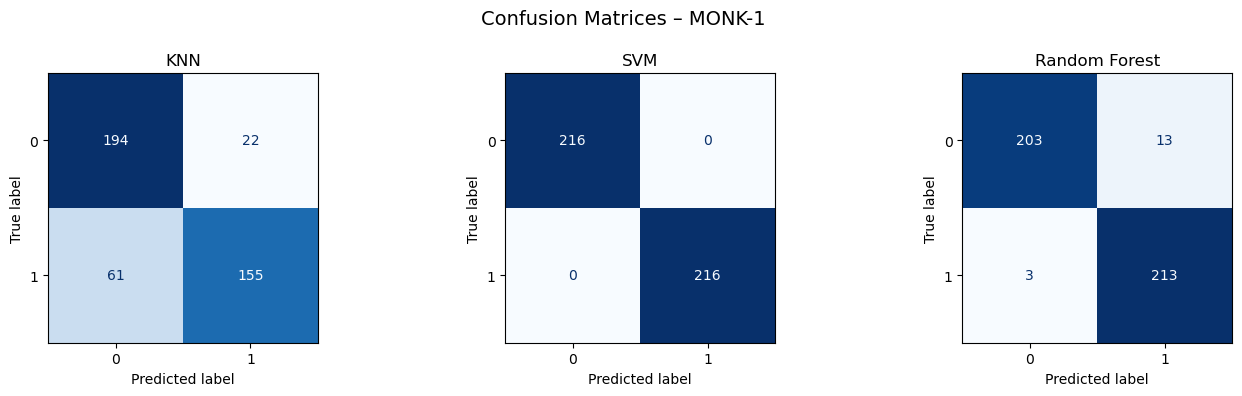

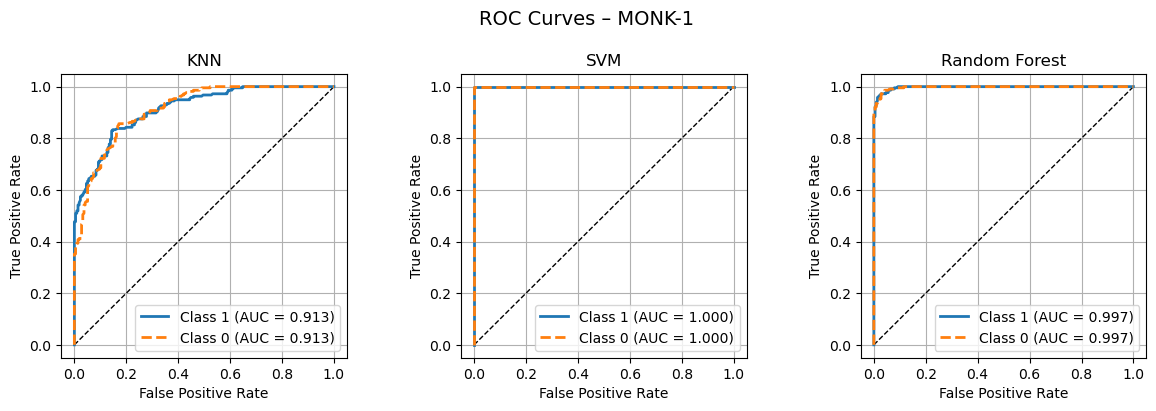


MONK-2 | MODEL: KNN
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best CV accuracy: 0.6569548872180451
Best parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 24, 'clf__weights': 'distance'}
Test Accuracy: 0.7893518518518519
              precision    recall  f1-score   support

           0     0.7970    0.9207    0.8544       290
           1     0.7629    0.5211    0.6192       142

    accuracy                         0.7894       432
   macro avg     0.7800    0.7209    0.7368       432
weighted avg     0.7858    0.7894    0.7771       432


MONK-2 | MODEL: SVM
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best CV accuracy: 0.8110902255639098
Best parameters: {'clf__C': 10, 'clf__coef0': 1, 'clf__degree': 2, 'clf__gamma': 1, 'clf__kernel': 'poly'}
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       290
           1     1.0000    1.0000    1.0000       142

    accur

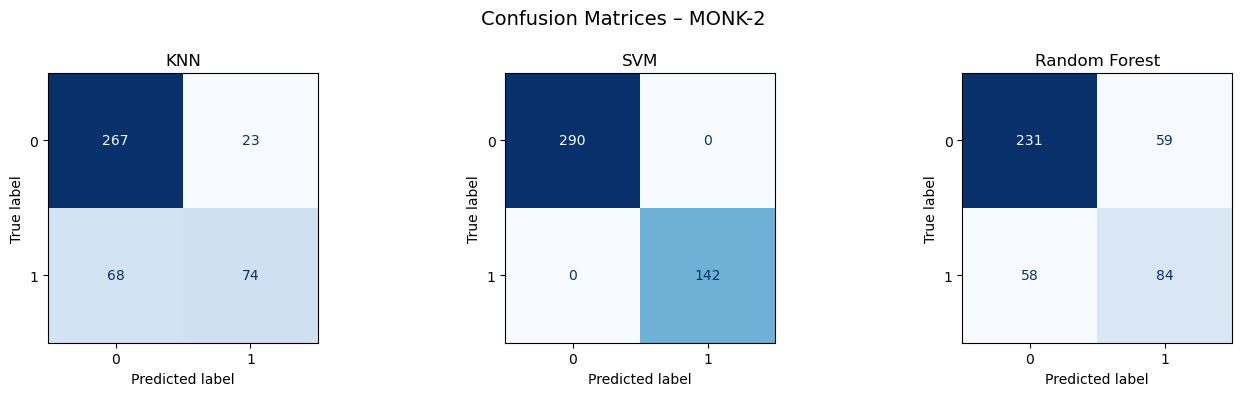

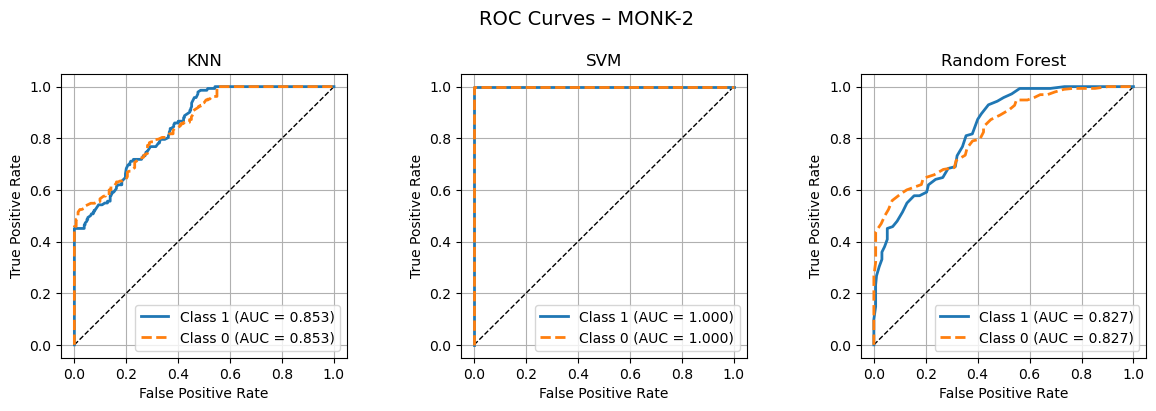


MONK-3 | MODEL: KNN
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best CV accuracy: 0.9180894308943089
Best parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 11, 'clf__weights': 'distance'}
Test Accuracy: 0.9097222222222222
              precision    recall  f1-score   support

           0     0.9104    0.8971    0.9037       204
           1     0.9091    0.9211    0.9150       228

    accuracy                         0.9097       432
   macro avg     0.9098    0.9091    0.9094       432
weighted avg     0.9097    0.9097    0.9097       432


MONK-3 | MODEL: SVM
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best CV accuracy: 0.9510162601626017
Best parameters: {'clf__C': 1, 'clf__coef0': 1, 'clf__degree': 4, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}
Test Accuracy: 0.9861111111111112
              precision    recall  f1-score   support

           0     0.9714    1.0000    0.9855       204
           1     1.0000    0.9737    0.9867     

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CV accuracy: 0.9428861788617886
Best parameters: {'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Test Accuracy: 0.9745370370370371
              precision    recall  f1-score   support

           0     0.9573    0.9902    0.9735       204
           1     0.9910    0.9605    0.9755       228

    accuracy                         0.9745       432
   macro avg     0.9741    0.9754    0.9745       432
weighted avg     0.9751    0.9745    0.9746       432



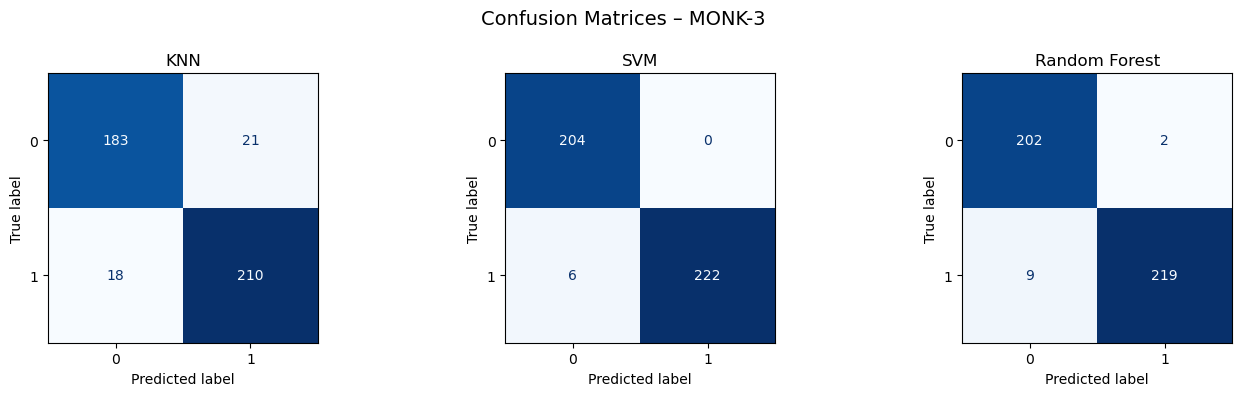

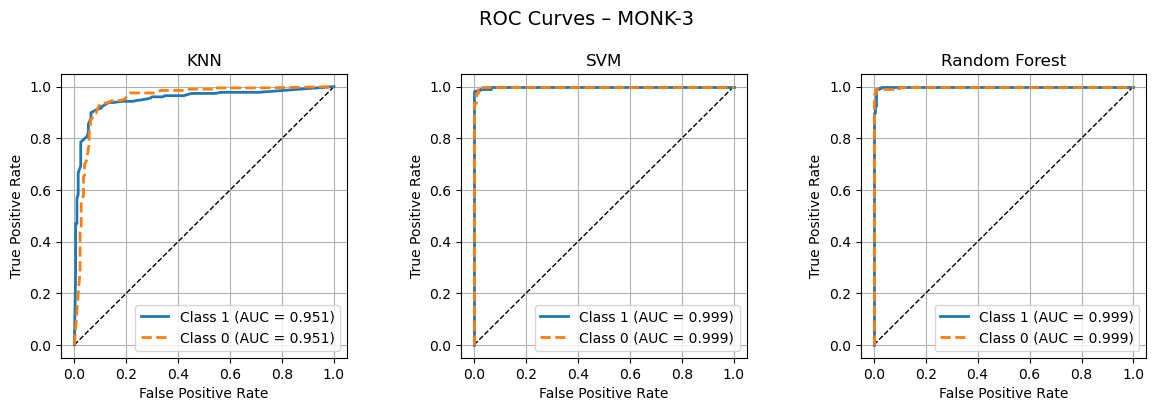

In [8]:
run_monk(data_dir=".")


# K values vs cv accuracy

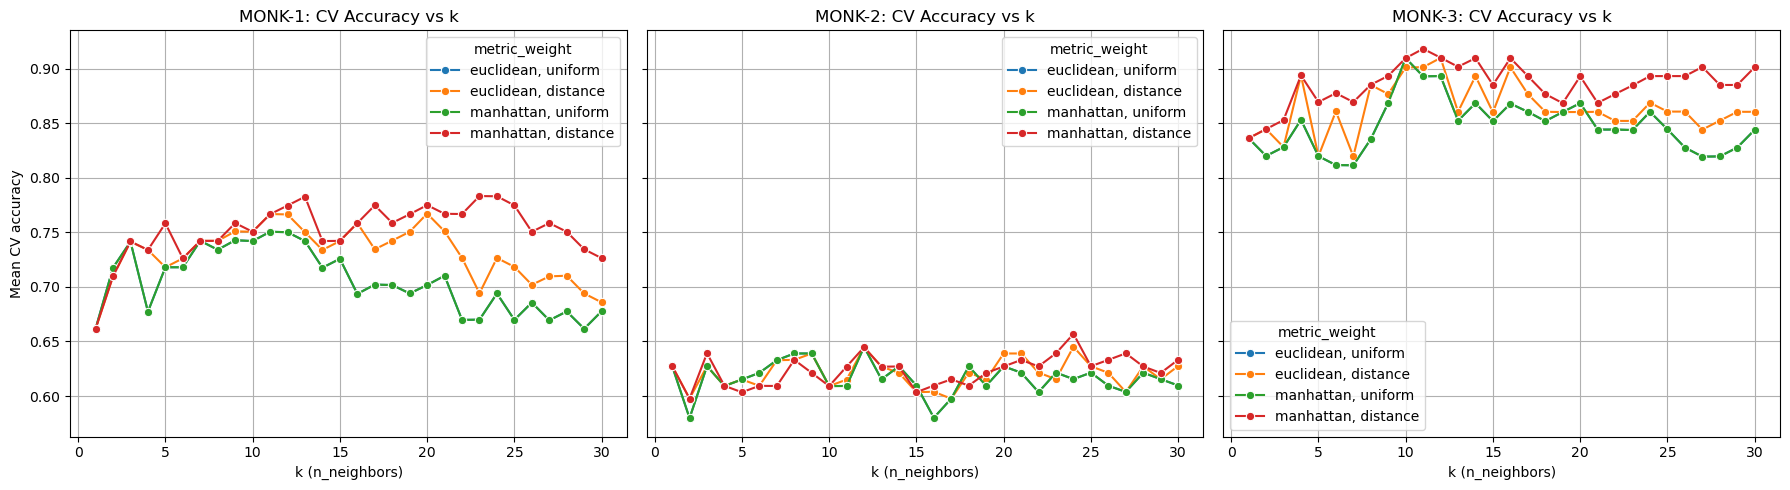


Best overall KNN setting per MONK:
  monk  k       metric_weight  mean_test_score
MONK-3 11 manhattan, distance         0.918089
MONK-1 23 manhattan, distance         0.783198
MONK-2 24 manhattan, distance         0.656955

Best k per MONK and per (metric, weight):
  monk       metric_weight  k  mean_test_score
MONK-1 euclidean, distance 20         0.767131
MONK-1  euclidean, uniform 11         0.750484
MONK-1 manhattan, distance 23         0.783198
MONK-1  manhattan, uniform 11         0.750484
MONK-2 euclidean, distance 24         0.645155
MONK-2  euclidean, uniform 12         0.645050
MONK-2 manhattan, distance 24         0.656955
MONK-2  manhattan, uniform 12         0.645050
MONK-3 euclidean, distance 12         0.909756
MONK-3  euclidean, uniform 10         0.909553
MONK-3 manhattan, distance 11         0.918089
MONK-3  manhattan, uniform 10         0.909553


In [ ]:


def knn_grid_results_for_monk(monk_id, data_dir=".", k_range=range(1, 31)):
   
    X_train, y_train, X_test, y_test = load_and_preprocess_monk_local(monk_id, data_dir)

    pipe = Pipeline([("clf", KNeighborsClassifier())])

    param_grid = {
        "clf__n_neighbors": list(k_range),
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["euclidean", "manhattan"],  
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=0,
        refit=False,  
        return_train_score=False
    )

    grid.fit(X_train, y_train)

    results = pd.DataFrame(grid.cv_results_)
    results["monk"] = f"MONK-{monk_id}"

    
    results["metric_weight"] = (
        results["param_clf__metric"].astype(str) + ", " + results["param_clf__weights"].astype(str)
    )

   
    results["k"] = results["param_clf__n_neighbors"].astype(int)

    return results



all_results = pd.concat(
    [knn_grid_results_for_monk(i, data_dir=".", k_range=range(1, 31)) for i in [1, 2, 3]],
    ignore_index=True
)


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    sub = all_results[all_results["monk"] == f"MONK-{monk_id}"]
    sns.lineplot(
        data=sub,
        x="k",
        y="mean_test_score",
        hue="metric_weight",
        marker="o",
        ax=ax
    )
    ax.set_title(f"MONK-{monk_id}: CV Accuracy vs k")
    ax.set_xlabel("k (n_neighbors)")
    ax.set_ylabel("Mean CV accuracy")
    ax.grid(True)

plt.tight_layout()
plt.show()

# --------- Optional: print best k per MONK (overall best setting) ----------
best_overall = (
    all_results.sort_values("mean_test_score", ascending=False)
              .groupby("monk", as_index=False)
              .head(1)[["monk", "k", "metric_weight", "mean_test_score"]]
)

print("\nBest overall KNN setting per MONK:")
print(best_overall.to_string(index=False))

# --------- Optional: best k per MONK and per metric/weight combo ----------
best_by_combo = (
    all_results.sort_values("mean_test_score", ascending=False)
              .groupby(["monk", "metric_weight"], as_index=False)
              .head(1)[["monk", "metric_weight", "k", "mean_test_score"]]
              .sort_values(["monk", "metric_weight"])
)

print("\nBest k per MONK and per (metric, weight):")
print(best_by_combo.to_string(index=False))


# Effect of numbers of estimators

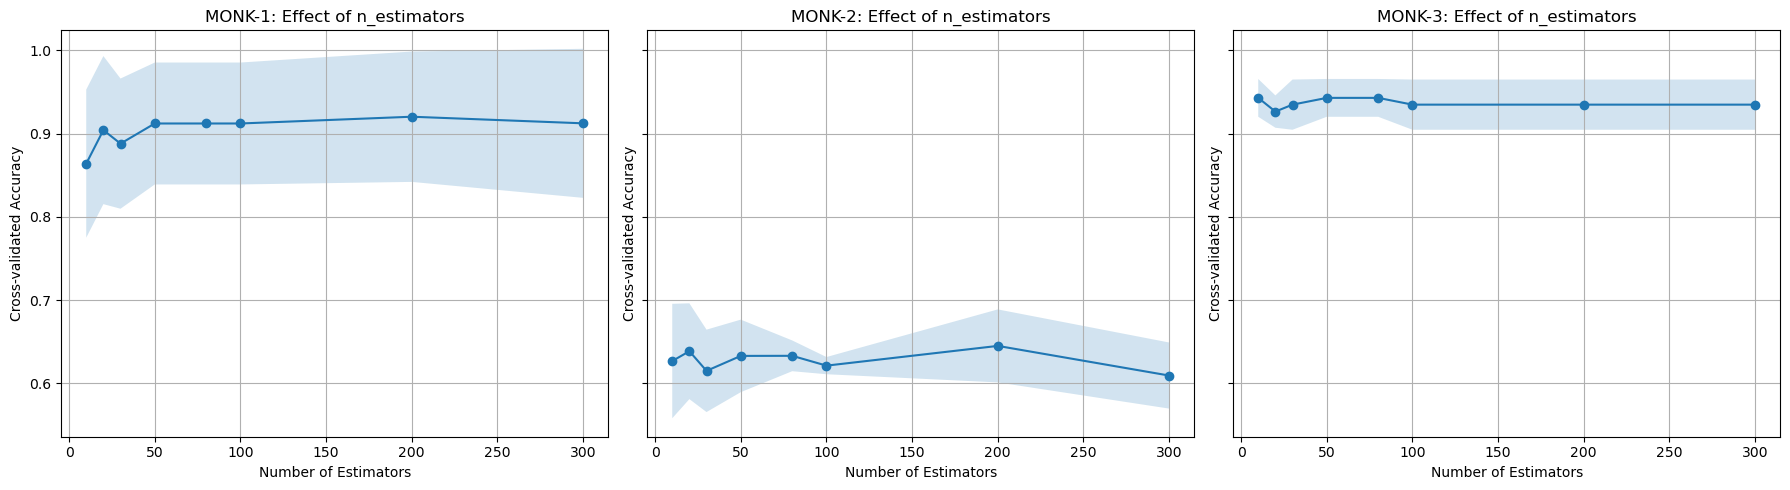

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


def rf_n_estimators_curve(
    monk_id,
    data_dir=".",
    n_estimators_list=(10, 25, 50, 100, 200, 300, 400, 500),
    max_depth=None,
    max_features=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
):
    # your preprocessing
    X_train, y_train, _, _ = load_and_preprocess_monk_local(monk_id, data_dir)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

    mean_acc = []
    std_acc = []

    for n in n_estimators_list:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )

        scores = cross_val_score(
            rf,
            X_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        )

        mean_acc.append(scores.mean())
        std_acc.append(scores.std())

    return np.array(n_estimators_list), np.array(mean_acc), np.array(std_acc)


# ---------------------------------------------------
# PLOT FOR MONK 1 / 2 / 3
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    n_list, acc_mean, acc_std = rf_n_estimators_curve(
        monk_id,
        data_dir=".",
        n_estimators_list=(10, 20, 30, 50, 80,100, 200, 300)
    )

    ax.plot(n_list, acc_mean, marker="o")
    ax.fill_between(
        n_list,
        acc_mean - acc_std,
        acc_mean + acc_std,
        alpha=0.2
    )

    ax.set_title(f"MONK-{monk_id}: Effect of n_estimators")
    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("Cross-validated Accuracy")
    ax.grid(True)

plt.tight_layout()
plt.show()


# Effect of max_depth

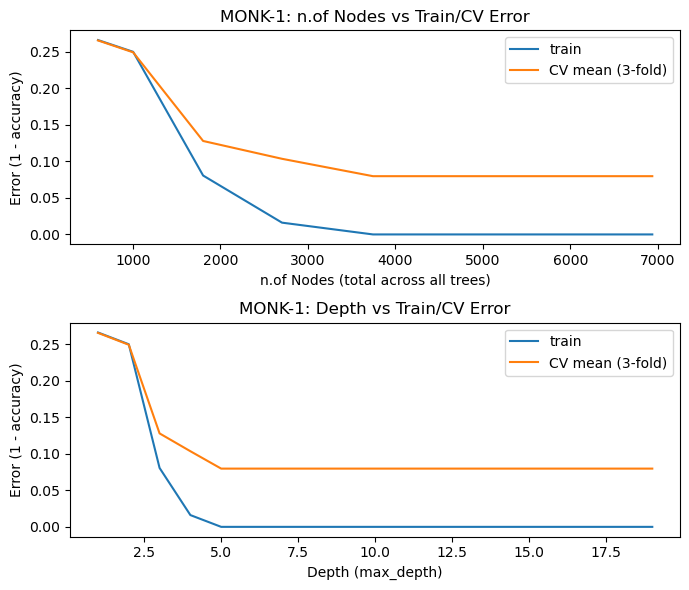

MONK-1: Best max_depth by CV = 5 (CV acc ≈ 0.9202)


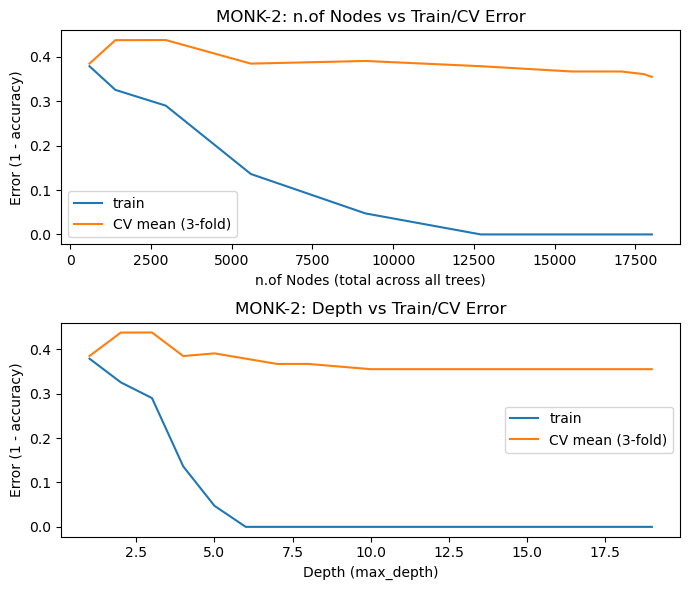

MONK-2: Best max_depth by CV = 10 (CV acc ≈ 0.6449)


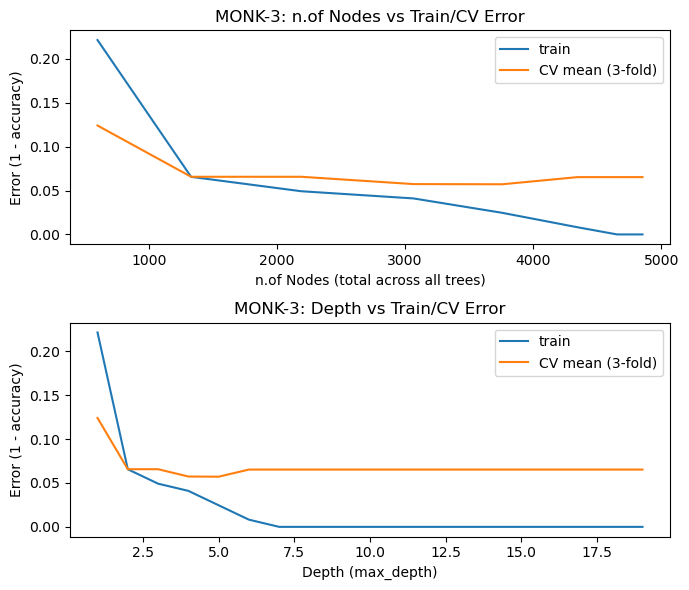

MONK-3: Best max_depth by CV = 5 (CV acc ≈ 0.9429)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score


def rf_nodes_depth_train_cv_error_plot(
    monk_id, data_dir=".",
    depth_range=range(1, 20),
    n_estimators=200,
    max_features=None,
    min_samples_split=2,
    min_samples_leaf=1,
    cv_splits=3,
    random_state=42
):
    X_train, y_train, X_test, y_test = load_and_preprocess_monk_local(monk_id, data_dir)

    nodes = []
    train_err = []
    cv_err_mean = []
    cv_err_std = []

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for max_depth in depth_range:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )

        # ---- CV accuracy on TRAIN only ----
        cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # ---- Train accuracy (fit on all training data) ----
        rf.fit(X_train, y_train)
        y_train_pred = rf.predict(X_train)
        tr_acc = accuracy_score(y_train, y_train_pred)

        # ---- Total nodes (after fit) ----
        total_nodes = sum(est.tree_.node_count for est in rf.estimators_)

        # store errors
        nodes.append(total_nodes)
        train_err.append(1 - tr_acc)
        cv_err_mean.append(1 - cv_mean)
        cv_err_std.append(cv_std)  # std is on accuracy (we'll handle in plot)

    # ------------------ PLOT (same style) ------------------
    fig, ax = plt.subplots(2, 1, figsize=(7, 6))

    # 1) Nodes vs Error (train vs CV)
    ax[0].plot(nodes, train_err, label="train")
    ax[0].plot(nodes, cv_err_mean, label=f"CV mean ({cv_splits}-fold)")
    ax[0].legend()
    ax[0].set_xlabel("n.of Nodes (total across all trees)")
    ax[0].set_ylabel("Error (1 - accuracy)")
    ax[0].set_title(f"MONK-{monk_id}: n.of Nodes vs Train/CV Error")

    # 2) Depth vs Error (train vs CV)
    ax[1].plot(list(depth_range), train_err, label="train")
    ax[1].plot(list(depth_range), cv_err_mean, label=f"CV mean ({cv_splits}-fold)")
    ax[1].legend()
    ax[1].set_xlabel("Depth (max_depth)")
    ax[1].set_ylabel("Error (1 - accuracy)")
    ax[1].set_title(f"MONK-{monk_id}: Depth vs Train/CV Error")

    plt.tight_layout()
    plt.show()

    # Optional: best depth by CV error
    best_i = int(np.argmin(cv_err_mean))
    best_depth = list(depth_range)[best_i]
    print(f"MONK-{monk_id}: Best max_depth by CV = {best_depth} (CV acc ≈ {1 - cv_err_mean[best_i]:.4f})")


# Run for MONK 1 / 2 / 3 (CV-based)
rf_nodes_depth_train_cv_error_plot(1, data_dir=".")
rf_nodes_depth_train_cv_error_plot(2, data_dir=".")
rf_nodes_depth_train_cv_error_plot(3, data_dir=".")


# Effect of C

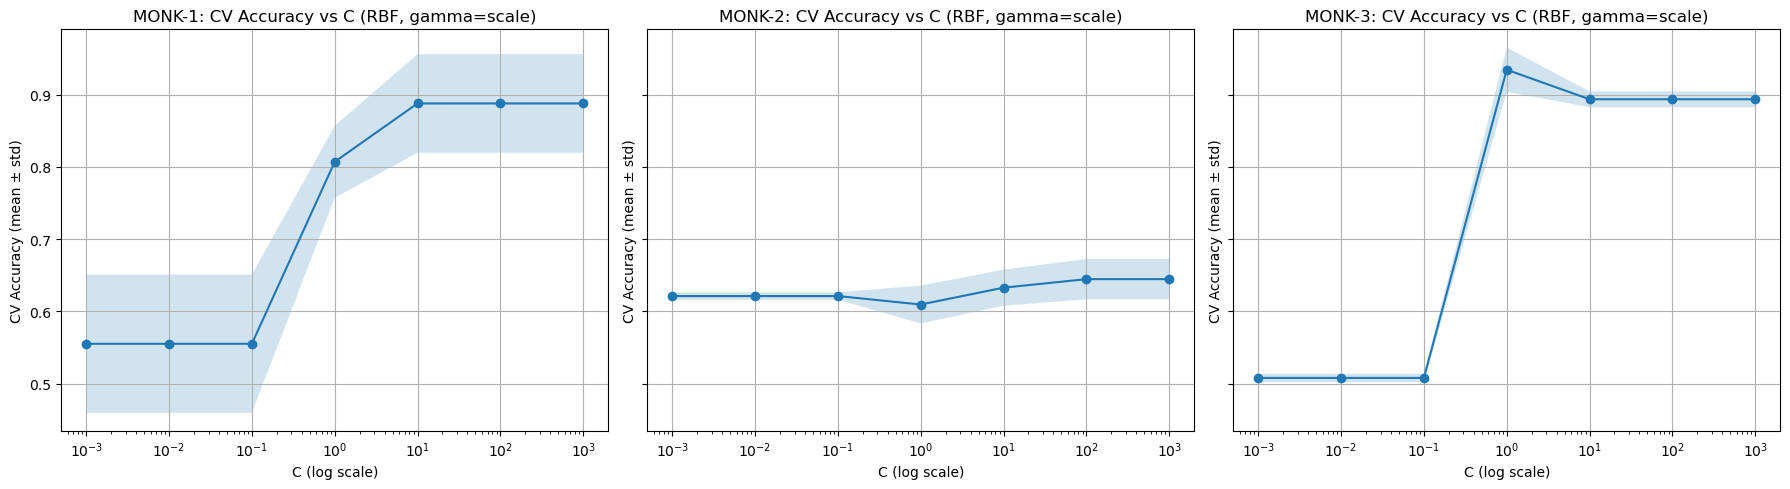

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


def svm_cv_curve_vs_C(monk_id, data_dir=".",
                      C_list=(0.001, 0.01, 0.1, 1, 10, 100, 1000),
                      kernel="rbf",
                      gamma="scale",
                      cv_splits=3,
                      random_state=42):
    X_train, y_train, _, _ = load_and_preprocess_monk_local(monk_id, data_dir)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    means, stds = [], []
    for C in C_list:
        clf = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
        means.append(scores.mean())
        stds.append(scores.std())

    return np.array(C_list), np.array(means), np.array(stds)


# ---------------- PLOT MONK 1/2/3 ----------------
C_list = (0.001, 0.01, 0.1, 1, 10, 100, 1000)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    Cs, mean_acc, std_acc = svm_cv_curve_vs_C(
        monk_id,
        data_dir=".",
        C_list=C_list,
        kernel="rbf",
        gamma="scale",   # keep fixed so we only study C
        cv_splits=3
    )

    ax.plot(Cs, mean_acc, marker="o")
    ax.fill_between(Cs, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

    ax.set_xscale("log")
    ax.set_title(f"MONK-{monk_id}: CV Accuracy vs C (RBF, gamma=scale)")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("CV Accuracy (mean ± std)")
    ax.grid(True)

plt.tight_layout()
plt.show()


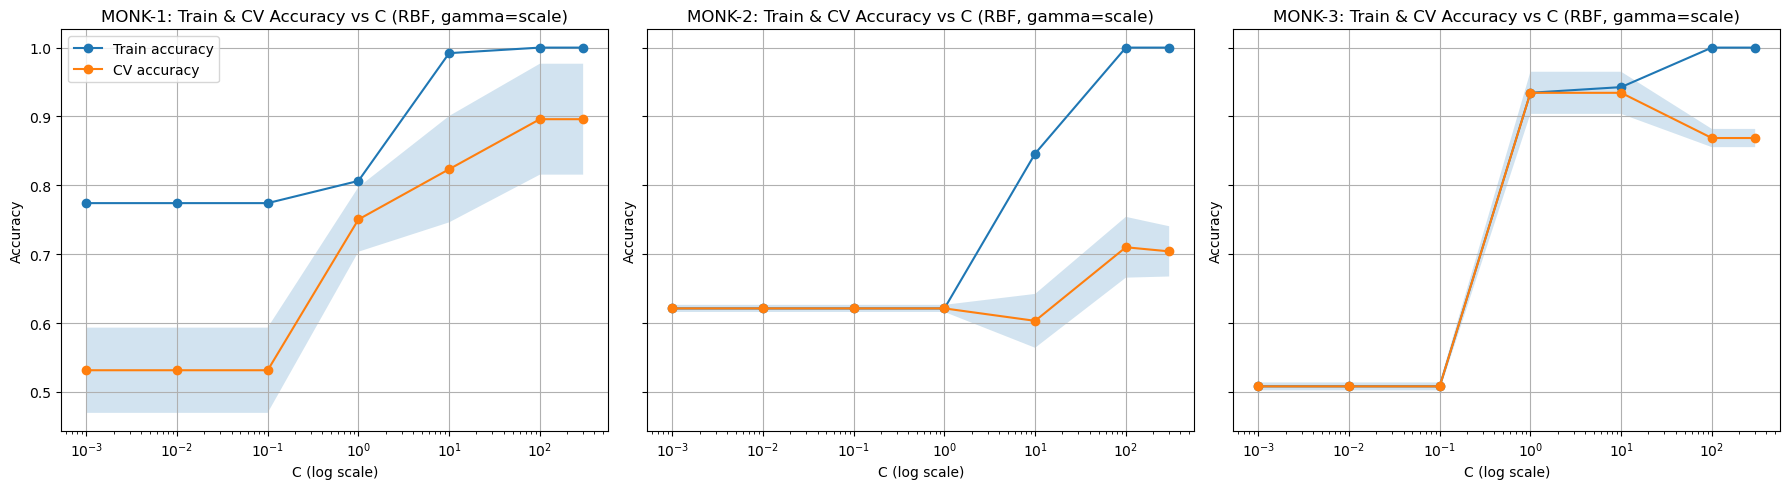

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score


def svm_train_and_cv_vs_C(
    monk_id,
    data_dir=".",
    C_list=(1e-3, 1e-2, 1e-1, 1, 10, 100, 1000),
    kernel="rbf",
    gamma="scale",
    cv_splits=3,
    random_state=42
):
    # Load one-hot encoded training data
    X_train, y_train, _, _ = load_and_preprocess_monk_local(monk_id, data_dir)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    train_acc = []
    cv_mean = []
    cv_std = []

    for C in C_list:
        clf = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)

        # ---- Cross-validated accuracy ----
        scores = cross_val_score(
            clf,
            X_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        )
        cv_mean.append(scores.mean())
        cv_std.append(scores.std())

        # ---- Training accuracy ----
        clf.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, clf.predict(X_train)))

    return (
        np.array(C_list),
        np.array(train_acc),
        np.array(cv_mean),
        np.array(cv_std)
    )


# -------------------------------
# PLOT FOR MONK 1 / 2 / 3
# -------------------------------
C_list = (1e-3, 1e-2, 1e-1, 1, 10, 100, 300)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    Cs, train_acc, cv_mean, cv_std = svm_train_and_cv_vs_C(
        monk_id,
        data_dir=".",
        C_list=C_list,
        kernel="rbf",
        gamma="auto",
        cv_splits=3
    )

    # Train accuracy
    ax.plot(Cs, train_acc, marker="o", label="Train accuracy")

    # CV accuracy
    ax.plot(Cs, cv_mean, marker="o", label="CV accuracy")
    ax.fill_between(Cs, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2)

    ax.set_xscale("log")
    ax.set_title(f"MONK-{monk_id}: Train & CV Accuracy vs C (RBF, gamma=scale)")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    if monk_id == 1:
        ax.legend()

plt.tight_layout()
plt.show()


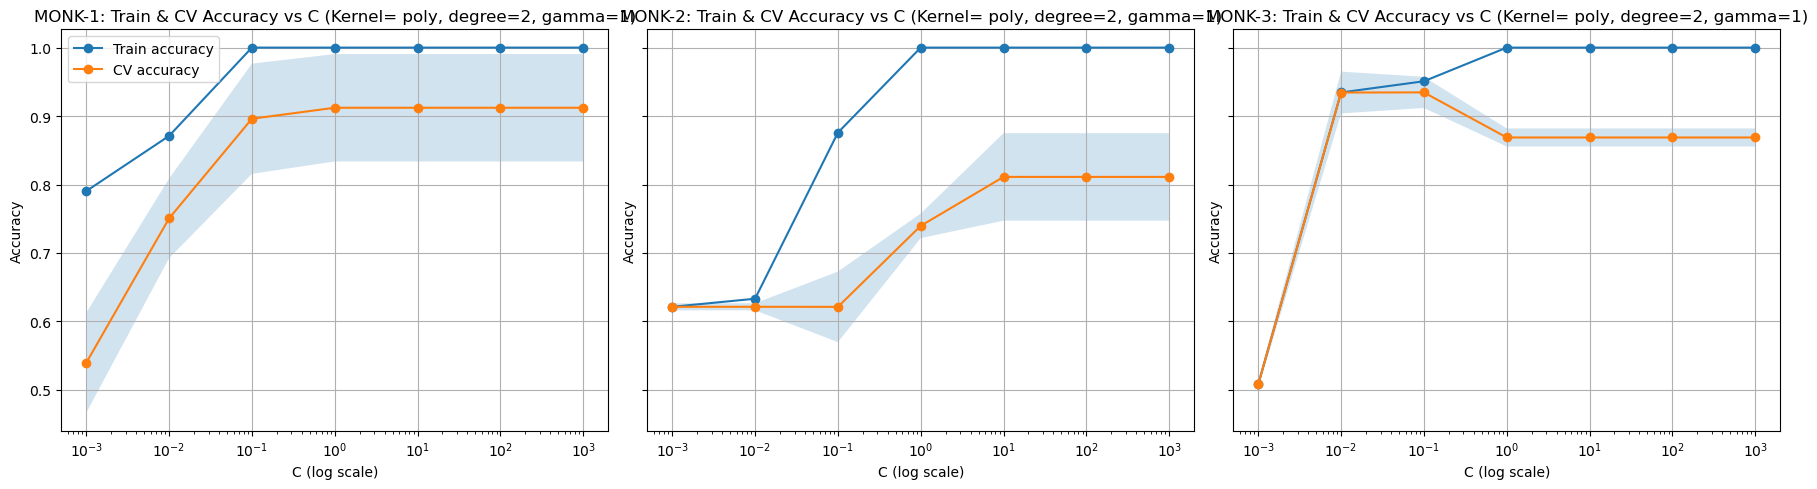

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score


def svm_train_and_cv_vs_C_gamma_auto(
    monk_id,
    data_dir=".",
    C_list=(1e-3, 1e-2, 1e-1, 1, 10, 100, 1000),
    cv_splits=3,
    random_state=42
):
    # load one-hot encoded training data
    X_train, y_train, _, _ = load_and_preprocess_monk_local(monk_id, data_dir)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    train_acc = []
    cv_mean = []
    cv_std = []

    for C in C_list:
        clf = SVC(
            kernel="poly",
            C=C,
            gamma=1, 
            coef0=1,
            degree=2,
            random_state=random_state
        )

        # ---- CV accuracy ----
        scores = cross_val_score(
            clf,
            X_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        )
        cv_mean.append(scores.mean())
        cv_std.append(scores.std())

        # ---- Train accuracy ----
        clf.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, clf.predict(X_train)))

    return (
        np.array(C_list),
        np.array(train_acc),
        np.array(cv_mean),
        np.array(cv_std)
    )


# -------------------------------
# PLOT FOR MONK 1 / 2 / 3
# -------------------------------
C_list = (1e-3, 1e-2, 1e-1, 1, 10, 100, 1000)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    Cs, train_acc, cv_mean, cv_std = svm_train_and_cv_vs_C_gamma_auto(
        monk_id,
        data_dir=".",
        C_list=C_list
    )

    # Train accuracy
    ax.plot(Cs, train_acc, marker="o", label="Train accuracy")

    # CV accuracy
    ax.plot(Cs, cv_mean, marker="o", label="CV accuracy")
    ax.fill_between(Cs, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2)

    ax.set_xscale("log")
    ax.set_title(f"MONK-{monk_id}: Train & CV Accuracy vs C (Kernel= poly, degree=2, gamma=1)")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    if monk_id == 1:
        ax.legend()

plt.tight_layout()
plt.show()


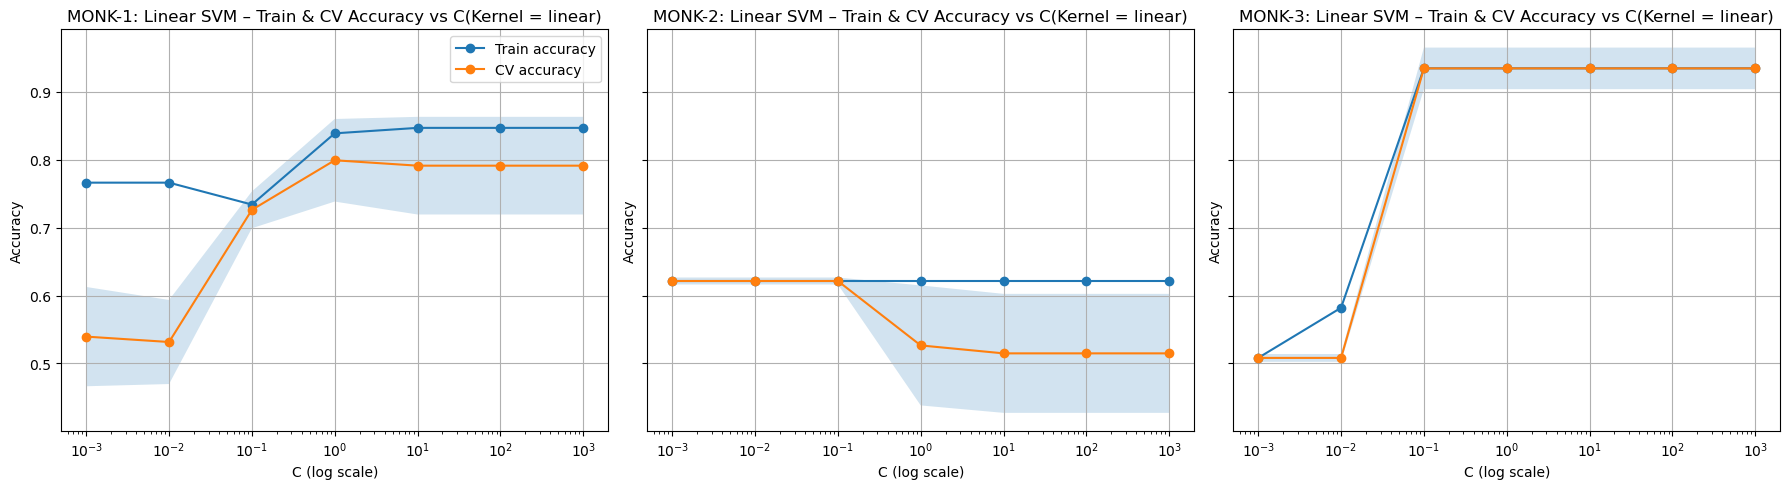

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score


def svm_linear_train_and_cv_vs_C(
    monk_id,
    data_dir=".",
    C_list=(1e-3, 1e-2, 1e-1, 1, 10, 100, 1000),
    cv_splits=3,
    random_state=42
):
    # Load one-hot encoded training data
    X_train, y_train, _, _ = load_and_preprocess_monk_local(monk_id, data_dir)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    train_acc = []
    cv_mean = []
    cv_std = []

    for C in C_list:
        clf = SVC(
            kernel="linear",  
            C=C,
            gamma="scale",
            random_state=random_state
        )

        # ---- Cross-validated accuracy ----
        scores = cross_val_score(
            clf,
            X_train,
            y_train,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        )
        cv_mean.append(scores.mean())
        cv_std.append(scores.std())

        # ---- Training accuracy ----
        clf.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, clf.predict(X_train)))

    return (
        np.array(C_list),
        np.array(train_acc),
        np.array(cv_mean),
        np.array(cv_std)
    )


# -------------------------------
# PLOT FOR MONK 1 / 2 / 3
# -------------------------------
C_list = (1e-3, 1e-2, 1e-1, 1, 10, 100, 1000)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, monk_id in zip(axes, [1, 2, 3]):
    Cs, train_acc, cv_mean, cv_std = svm_linear_train_and_cv_vs_C(
        monk_id,
        data_dir=".",
        C_list=C_list
    )

    # Train accuracy
    ax.plot(Cs, train_acc, marker="o", label="Train accuracy")

    # CV accuracy
    ax.plot(Cs, cv_mean, marker="o", label="CV accuracy")
    ax.fill_between(Cs, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2)

    ax.set_xscale("log")
    ax.set_title(f"MONK-{monk_id}: Linear SVM – Train & CV Accuracy vs C(Kernel = linear)")
    ax.set_xlabel("C (log scale)")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    if monk_id == 1:
        ax.legend()

plt.tight_layout()
plt.show()
